In [1]:
import pandas as pd
import numpy as np
import wikipedia as wiki
from bs4 import BeautifulSoup
from optional import Optional
import geocoder
import random

import os
os.environ["PROJ_LIB"] = "C:\\Users\\Tali\\Anaconda3\\Library\\share";
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)



In [44]:
def getArtistOrigin(name: str):
    result = getOriginFromWikipedia(name + " musician")
    
    if result.is_present():
        toReturn = result.get()
    else:
        print("Still not found!", name)
        toReturn = "Not Found"
        
    return toReturn

def getOriginFromWikipedia(name: str):
    toReturn = Optional.empty()
    artistPage = wiki.page(wiki.search(name)[0], auto_suggest=False).html()
    
    bs = BeautifulSoup(artistPage)
    
    tables = bs.find_all("table")
    
    tab = None
    for tab in tables:
        if "infobox" in tab["class"]:
            break
            
    if tab != None:
        # search for 'origin' to return
        titles = [heading.text.strip() for heading in tab.find_all("th")]
        titles.pop(0)
        data = [data.text.strip() for data in tab.find_all("td")]

        for key, value in zip(titles, data):
            if key =="Origin":
                toReturn = Optional.of(value)
                
        # edge case for some solo artists, find birthplace
        if toReturn == Optional.empty():
            for div in tab.find_all("div", {"class": "birthplace"}):
                if "birthplace" in div["class"]:
                    toReturn = Optional.of(div.text.strip())
        
        # worse case, birthplace not tagged
        if toReturn == Optional.empty():
            for key, value in zip(titles, data):
                if key =="Born":
                    try:
                        index = value.index("age")
                    except:
                        index = 0
                    value = value[index+7:]
                    toReturn = Optional.of(value)
                if key =="Died":
                    try:
                        index = value.index("age")
                    except:
                        index = 0
                    index = value.index("age")
                    value = value[index+7:]
                    toReturn = Optional.of(value)
                    

    return toReturn

In [28]:
# simple test
assert getArtistOrigin("DaBaby") == 'Charlotte, North Carolina'

In [47]:
def createDataframe(artist_list):
    location_name = [getArtistOrigin(artist) for artist in artist_list]
    location_coord = [getLocationByGeo(loc) for loc in location_name]
    df = pd.DataFrame({"artist_name" : artist_list, "location_name" : location_name, "location_coord": location_coord })
    return df
                     
## https://stackoverflow.com/questions/56873950/convert-place-name-to-coordinates-by-geopy
def getLocationByGeo(name):
    try: 
        index = name.index("[")
        name = name[0:index]
    except:
        name = name
    g = geocoder.osm(name)
    return g.latlng

In [51]:
sample_artists = ["vampire weekend", "jukebox the ghost", "smallpools", "tally hall", "daft punk", "luis fonsi", "midnight oil", "dodie", ""]
df = createDataframe(sample_artists)
df

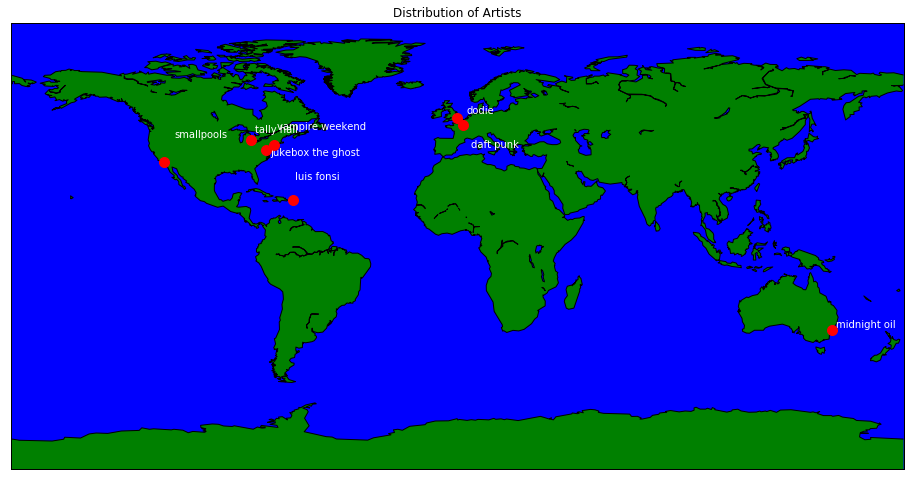

In [61]:
fig = plt.figure(figsize=(16, 10), edgecolor='w')
m = Basemap(projection='cyl', lat_0=0, lon_0=0)

m.drawmapboundary(fill_color='blue')
m.fillcontinents(color='green',lake_color='blue')
m.drawcoastlines()

plt.title("Distribution of Artists")


lons = []
lats = []
for coord in df["location_coord"]:
    lats.append(coord[0])
    lons.append(coord[1])

x, y = m(lons, lats)  # transform coordinates
m.scatter(x, y, 100, marker='o', color='Red', zorder=10) 
for i, name in enumerate(df["artist_name"]):
    plt.annotate(name, xy=(x[i], y[i]), xytext=(x[i] + 5*(random.random()), y[i] + 20*(random.random() - 0.5) ), xycoords='data', color='w')
plt.show()